---
# Multiaxial Cyclic Plasticity Model for Clays - Bounding Surface Formulation and Implementation
---
> Copyright ©2019 Arduino Computational Geomechanics Group and Justin Bonus.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CESG 508 for use solely during Winter Quarter 2020 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these materials should contact the author.
---

Here we will look at a constitutive model that aims to capture the kinematic hardening effects of stress unloading on 3D constitutive response. This model notably adjusts its nonlinear response relative to the last point of unloading, allowing it to replicate observed behavior of soils under rapidly unloading/reloading cases (e.g. earthquakes, induced vibration, train loadings). 

While more complex models exist that better capture this effect, along with other phenomenea such as liquefaction, this specific model serves as a good starting point for understanding how 'unloading' and 'reloading' can be defined mathematically and implemented computationaly. This model is also effective at demonstrating material limits, as a 'bounding surface' is implemented which prevents the stress from exceeding the undrained shear strength you would measure in a lab or field setting.

It is generally a good idea to restart the kernel and run all cells sequentially to make sure the code runs correctly.

A number of common libraries must be imported to use/edit the entire notebook in the .ipynb format. 
 - ```numpy``` - For basic math and array manipulation
 - ```collections.namedtuple``` - For variable structures
 - ```scipy``` - For some linear algebra
 - ```matplotlib``` - For data visualization
 - ```mpl_toolkits``` - For 3D plotting
 - ```ffmpeg``` - For animation embedment

For those using the notebook in .html format it is unneccesary to install any packages.

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# For basic math, arrays, and structures
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib

In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
# Import various functions
%run ~/School/CESG508/'Bounding Surface'/Utilities.ipynb
%run ~/School/CESG508/'Bounding Surface'/Visuals.ipynb
%run ~/School/CESG508/'Bounding Surface'/Animations.ipynb

## Visualizing in 3D

Constitutive models can be difficult to imagine. To start things off, lets play around with a 3D visualization of the model in normal principal stress space. The math behind the model won't make sense yet, but hopefully this will give you a stronger mental image of what is happening as we go over the derivation later on.

How to navigate:
 * ```Free View``` - Click and drag around the scene to view from whatever perspective you like.
 * ```$\Pi$-Plane``` - Sets the view to look down the hydrostatic axis, a line where all the stress values are equal (i.e. a view where volumetric stress is removed).
 * ```$X$-View``` - Sets the view to look down the $\sigma_3$ axis. Not especially useful, but helps to orient yourself.

How to manipulate:
 * ```$R$``` - Controls the radius of the black cylinder (Bounding Surface). Play with the slider to observe how it effects the visualization.
 * ```$r$``` - Controls the radius of the blue cylinder (Yield Surface). This is a purely geometric construct that is useful for the derivation, but fairly nonsensical to observe.
 * ```$\sigma_1$ $\sigma_2$ $\sigma_3$``` - Principal normal stress value of the last 'unloading' point. Notice how many of the cylinders seem to change position relative to these three sliders. 

How to interpret:
 * ```Bounding Surface``` - The black cylinder around the model. Notice that the stress can not exceed its bounds.
 * ```Yield Surface``` - This is a purely geometric construct used during the later derivation. It represents the distance of the active stress point from the unloading point. This value, when used to construct a cylinder, can exceed the bounding surface, however, the active stress can never actually do this. 
 * ```$\kappa$ Contours``` - The coloured cylinders that move with the unloading point. They represent equivalues contours of $\kappa$, or alternatively of the hardening moduli, $H'$. These values are abstract for now, but they control the nonlinear response of the model (i.e. the lower the value the lower the stress-to-strain ratio). In reality there are an infinite number of these contours, though only a few are plotted. Note that none of them will ever exit the bounding surface, and that they will always remain inline with the unloading stress in the $\Pi$-plane
 
 **Interactive buttons are broken when referencing a different notebook, sliders will still work**

<IPython.core.display.Javascript object>


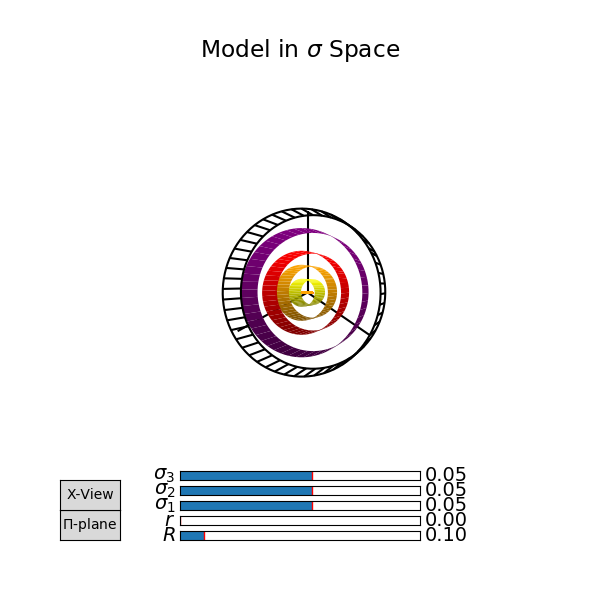

In [11]:
borjasInteractive()

--- 
## $I$. Terminology and Variables
Listed are the variables we will be using:

$ \pmb{\epsilon}: 2^{\text{nd}} \text{ Order Strain Tensor} $

$ \pmb{\sigma}: 2^{\text{nd}} \text{ Order Stress Tensor} $

$ R: \text{ Bounding Surface Radius} $

$ r $

$ \kappa: \text{ Non-linear scalar parameter} $

$ H': \text{ Hardening Modulus} $

$ \psi $

$ \theta $

$ A $


$ \pmb{D} = \text{4th-Order Flexiblity Tensor} $

$ \pmb{D^{-1}} = \text{4th-Order Stiffness Tensor} $

$ : \space = \text{Inner-Product Operator} $

$ \delta = \text{Differential Operator} $

$ E = \text{Young's Modulus} $

$ \nu = \text{Poisson's Ratio} $

$ K = \text{Bulk Modulus} $

$ G = \text{Shear Modulus} $

We define the Cauchy stress-tensor as follows for a 3D stress-state

$$ \pmb{\sigma} = \begin{pmatrix} \sigma_{xx} & \tau_{xy} & \tau_{xz} \\  \tau_{yx} & \sigma_{yy} & \tau_{yz} \\ \tau_{zx} & \tau_{zy} & \sigma_{zz}  \end{pmatrix} $$

By assuming symmetry of shear stresses we can reduce it to six elements. We then display in vector form for ease of computation

$$ \pmb{\sigma} = \begin{pmatrix} \sigma_{xx} \\ \sigma_{yy} \\ \sigma_{zz} \\  \tau_{xy}\\ \tau_{yz} \\ \tau_{xz} \end{pmatrix} $$

Similarily we vectorize strain

$$ \pmb{\epsilon} = \begin{pmatrix} \epsilon_{xx} \\ \epsilon_{yy} \\ \epsilon_{zz} \\  \gamma_{xy}\\ \gamma_{yz} \\ \gamma_{xz} \end{pmatrix} $$

Note that vector representations of a 2nd order stress/strain state tensor will affect how certain operations are performed mathematically. For this model it isn't a major concern.

--- 
## General Formulation
To begin the derivation we first define the components of the material strain rate, $\pmb{\dot{\epsilon}}$. This strain rate can be broken into an elastic and plastic portion.

$$\pmb{\dot{\epsilon}} = \pmb{\dot{\epsilon}}^{e} + \pmb{\dot{\epsilon}}^{p} $$

$$\pmb{\dot{\sigma}} = \pmb{C}^{e}:(\pmb{\dot{\epsilon}} - \pmb{\dot{\epsilon}}^{p}) = \pmb{\dot{\sigma}}^{tr} - 2\mu\lambda\pmb{\hat{n}} $$

$$F = \pmb{\zeta}':\pmb{\zeta}' - r^{2} = 0 $$

Where $\pmb{\zeta}' = \pmb{\sigma}' - \pmb{\alpha} $; $r = $ radius of the yield function; $\pmb{\sigma}' = \pmb{\sigma} - tr(\pmb{\sigma})\pmb{1}/3 = $ deviatoric part of $\pmb{\sigma} $; $\pmb{\alpha} = $ deviatoric back stress tensor representing the center of $F$.

$$\pmb{\dot{\alpha}}= \left\lVert \pmb{\dot{\alpha}} \right\rVert \pmb{\hat{n}} $$

Where $\left\lVert \pmb{\dot{\alpha}} \right\rVert = (\pmb{\dot{\alpha}}:\pmb{\dot{\alpha}})^{1/2} > 0 $ is the magnitude of $\pmb{\dot{\alpha}}$.

$$B = \pmb{\sigma}':\pmb{\sigma}' - R^{2} = 0$$

Or in a more familiar form:

$$R = \sqrt{\pmb{\sigma}':\pmb{\sigma}' - B} = \sqrt{2J_{2} - B}$$

Where $R > r$ and is the radius of the bounding Von Mises cylinder centered about the hydrostatic axis.

$$R = (\frac{8}{3})^{1/2}S_u $$

This bounding radius determines the deviatoric stress limit. Reaching the bounding surface would mean achieving perfect plasticity, which is fairly logical as the surface is based on the material's maximum undrained shear strength. Exceeding capacity causes complete failure in the form of plasticity.

The definitions for the boundary and yield surface produce Von Mises cylinders within a 3D stress space. The cylinders extend infinitly, with the bounding cylinder centered on the origin and the yield cylinder centered on the point of last unloading. 

Below is code to produce visual representations of the bounding (purple) and yielding (blue) surfaces. The hydrostatic axis (red) has been included, as well as an axis traveling through the last point of unloading (yellow). Together they demonstrate the yield surface's potential to move within the bounding surface, a result of kinematic hardening. The effect is best observed by orienting the plot so the hydrostatic axis appears to be a point.

A normal unit, $\pmb{\hat{n}}$, can be defined on the yield surface for all instances where $r \neq 0$.

$$\pmb{\hat{n}}=\frac{\pmb{\zeta}'}{r} $$

As r is present in the denominator it is apparent that setting it to zero will produce a division error. However, by taking the limit of the function as $r \rightarrow 0$ 

$$\pmb{\hat{n}}=\lim_{r \rightarrow 0}(\frac{\pmb{\zeta}'}{r}) $$

$$\pmb{\dot{\sigma}}'=2\mu\pmb{\dot{\epsilon}}'-2\mu\lambda\frac{\pmb{\dot{\sigma}}'}{\left\lVert \pmb{\dot{\sigma}}' \right\rVert} $$

$$\frac{\pmb{\zeta}'}{r}:\pmb{\zeta}'=\pmb{\hat{n}}:(\pmb{\dot{\sigma}}'-\pmb{\dot{\alpha}})=0 $$

$$\left\lVert \pmb{\dot{\alpha}} \right\rVert = \pmb{\hat{n}}:\pmb{\dot{\sigma}}' $$

$$\pmb{\hat{n}}=\frac{\pmb{\sigma}'}{\left\lVert \pmb{\sigma}' \right\rVert} $$

$$\left\lVert \pmb{\dot{\alpha}} \right\rVert = (\frac{2}{3})^{1/2} \dot{\bar{\sigma}} $$

$$\dot{\bar{\sigma}}=\pmb{H}'\dot{\bar{\epsilon}^{p}} $$

$$\dot{\bar{\epsilon}}=(\frac{2}{3})^{1/2}\left\lVert \pmb{\dot{\epsilon}^{p}} \right\rVert = (\frac{2}{3})^{1/2}\lambda $$

$$\left\lVert \pmb{\dot{\alpha}} \right\rVert = \frac{2}{3}\pmb{H}'\lambda $$

$$\left\lVert \pmb{\dot{\alpha}} \right\rVert = 2\mu(\left\lVert \pmb{\dot{\epsilon}}' \right\rVert - \lambda) $$

$$\lambda = (\frac{3\mu}{3\mu + \pmb{H}'})\left\lVert \pmb{\dot{\epsilon}}' \right\rVert $$

$$\pmb{\dot{\sigma}}=Ktr(\pmb{\dot{\epsilon}})\pmb{1} + 2\mu(1 + \frac{3\mu}{\pmb{H}'})^{-1}\pmb{\dot{\epsilon}}' $$

## $\kappa$ Function

The elegance of this model is derived from its $\kappa$ parameter. This non-dimensional, scalar value relates the maximum attainable stress (as defined by the bounding surface), $\pmb{\hat{\sigma}}'$, to the current stress and stress at point of last unloading, $\pmb{\sigma}'$ and $\pmb{\sigma}_{0}'$ respectively. In essence, it introduces the nonlinear relationship that ties the near-elastic constitutive response at the hydrostatic axis to the perfectly plastic response at the bounding surface.

$$\pmb{\hat{\sigma}}' = \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') $$

This $\kappa$ value is determined via upholding the following relationship:

$$ \left\lVert \pmb{\hat{\sigma}}' \right\rVert = \left\lVert \pmb{\sigma}' + \kappa(\pmb{\sigma}'-\pmb{\sigma}_{0}') \right\rVert = R $$

Basically we need to know $\pmb{\hat{\sigma}}'$, $\pmb{\sigma}'$, $\pmb{\sigma}_{0}'$, (stress-state values) and $R$ (material value) to find $\kappa$ deterministicly. 

---
## Hardening Function

$\kappa$ is always distributed in the same way relative to the bounding surface and unloading stress, regardless of any other parameter. Because of this every instance of this model will produce stress-strain responses of roughly the same shape, which we know does not represent the variability of real world geotechnical materials. 

To better tune this model to any material we may wish to work with we evolve $\kappa$ into something called a hardening modulus, $H'$. This new variable can be based on anything we choose, but will most often be limited by what material parameters we can gather.

Finely tuning these functions will allow for a very accurate replication of observed material behavior. Tuning can be done through altering parameters through lab testing or by formulating new functions that better represent behavior. Ultimately, simple functions that use as few parameters as possible tend to be preferred by practioners, and, in general, perform fairly well. Here are three common choices:

 - Exponential
This is the hardening function that we will use in this notebook. It's is very basic, needing only two additional parameters, and replicates soil behavior fairly well.
$$H' = h\kappa^{m} $$
 - Hyperbolic
$$\frac{\delta}{\delta_{in}} = \frac{\kappa}{1+\kappa} $$
$$H' = 3\mu\frac{\kappa^{2}}{1+2\kappa} $$

- Davidenkov
$$H' = 3\mu[\frac{1+\theta}{1+\theta+1}(1+\frac{1}{\theta})^{A}]-1 $$
$$\kappa = \frac{A}{\theta}[1-(\frac{\theta}{1+\theta})^{A}]^{-1}-1 $$
$$ \dot{H}' = \frac{dH'}{d\kappa} \dot{\kappa}$$
$$ \dot{\kappa} = -\frac{(1+\kappa)\pmb{\sigma}' + \kappa(1+\kappa)(\pmb{\sigma}'-\pmb{\sigma}'_{o})}{\pmb{\sigma}':(\pmb{\sigma}'-\pmb{\sigma}'_{o}) + \kappa ||\pmb{\sigma}'-\pmb{\sigma}'_{o}||^2}:\pmb{\hat{\sigma}}' $$

Where $\kappa$ is obtained from the nonextraneous root of ...

$$ -\frac{(1+\kappa)\pmb{\sigma}' + \kappa(1+\kappa)(\pmb{\sigma}'-\pmb{\sigma}'_{o})}{\pmb{\sigma}':(\pmb{\sigma}'-\pmb{\sigma}'_{o}) + \kappa ||\pmb{\sigma}'-\pmb{\sigma}'_{o}||^2}:\pmb{\dot{\epsilon}}' > 0 $$

In [1]:
visHardening()

NameError: name 'visHardening' is not defined

---

---
## Stress-Point Algorithm

Now that we've gone over the foundations of this model, its time to develop an algorithm that can return the stress or strain increment for a given timestep.

$$ -\lim_{\Delta t \rightarrow 0}[\frac{(1+\kappa)\pmb{\sigma}' + \kappa(1+\kappa)(\pmb{\sigma}'-\pmb{\sigma}'_{o})}{\pmb{\sigma}':(\pmb{\sigma}'-\pmb{\sigma}'_{o}) + \kappa ||\pmb{\sigma}'-\pmb{\sigma}'_{o}||^2}:\frac{\Delta\pmb{\epsilon}'}{\Delta t}] > 0 $$

$$ -\frac{(1+\kappa_n)\pmb{\sigma}_n' + \kappa_n(1+\kappa_n)(\pmb{\sigma}_n'-\pmb{\sigma}'_{on})}{\pmb{\sigma}':(\pmb{\sigma}_n'-\pmb{\sigma}'_{on}) + \kappa_n ||\pmb{\sigma}_n'-\pmb{\sigma}'_{on}||^2}:\Delta\pmb{\epsilon}' > 0 $$

$$ \Delta \pmb{\sigma} = K tr(\pmb{\epsilon})\pmb{1} + 2\mu \int_{t_n}^{t_n +1} (1 + \frac{3\mu}{H'})^{-1} d\pmb{\epsilon}' $$

$$ \dot{\pmb{\sigma}}' + \frac{3\mu}{H'}\dot{\pmb{\sigma}}' = 2\mu \dot{\pmb{\epsilon}}' $$

$$\Delta\pmb{\sigma}' + 3\mu(\frac{1-\beta}{H_n'} + \frac{\beta}{H_{n+1}'} )\Delta\pmb{\sigma}' = 2\mu\Delta\pmb{\epsilon}' $$

$$\psi + 3\mu\psi(\frac{1-\beta}{H_n'} + \frac{\beta}{H_{n+1}'}) = 2\mu $$

$$ R = ||\pmb{\sigma}'_n + \psi\Delta\pmb{\epsilon}' + \kappa_{n+1}(\pmb{\sigma}'_n + \psi\Delta\pmb{\epsilon}' - \pmb{\sigma}'_{0n})|| $$

Finally, we arrive at our constitutive equation. This is what we wanted from the start--An equation that considers the previous state, volumetric changes, and deviatoric changes in order to calculate the next state.

$$ \pmb{\sigma}_{n+1} = \pmb{\sigma}_n + K tr(\Delta\pmb{\epsilon})\pmb{1} + \psi\Delta\pmb{\epsilon}' $$

---
## Approximating Solutions



<IPython.core.display.Javascript object>


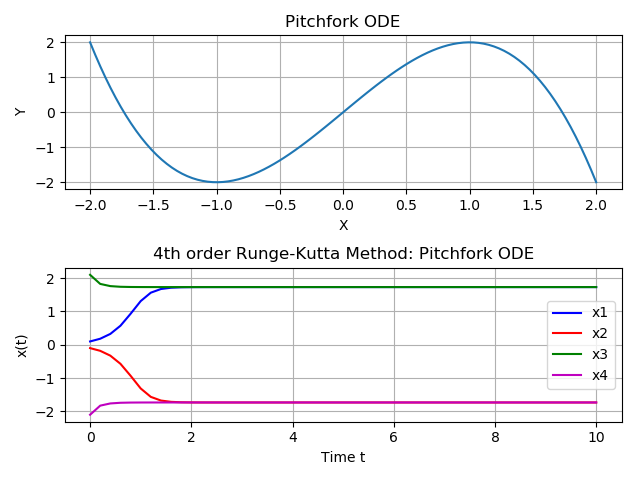

In [15]:
# Plot out time series of integration steps of a 1D ODE to illustrate the fourth-order Runge-Kutta Euler method.
#
# For 1D ODE
#     dx/dt = f(x)
# the Euler method integrates this ODE by
#     x'    = x_n + f( x_n ) * Delta t
#     x_n+1 = x_n + 1/2 * [ f( x_n ) + f(x') ] * Delta t
# where Delta t is the time step and time t = n * dt.
#

# Import plotting routines
from pylab import *

# 1D ODE that has a pitchfork bifurcation
def PitchforkODE(r,x):
    return r * x - x * x * x

# 1D Fourth-Order Runge-Kutta Integrator
def RKOneD(r,x,f,dt):
    k1 = dt * f(r,x)
    k2 = dt * f(r,x + k1/2.0)
    k3 = dt * f(r,x + k2/2.0)
    k4 = dt * f(r,x + k3)
    return x + ( k1 + 2.0 * k2 + 2.0 * k3 + k4 ) / 6.0

# Simulation parameters
r = 3.0 # Control parameter of the pitchfork ODE
t  = [ 0.0] # Starting time
dt = 0.20 # Integration time step
N = 50 # The number of time steps to integrate over

# Set up arrays of iterates for four different initital # conditions
x1 = [ 0.1]
x2 = [-0.1]
x3 = [ 2.1]
x4 = [-2.1]

x = np.linspace(-2,2,100)
y = PitchforkODE(r,x)
# The main loop that generates iterates and stores them
for n in range(0,N):
    # at each time step calculate new x(t)
    # and append to list x
    x1.append( RKOneD(r,x1[n],PitchforkODE,dt) )
    x2.append( RKOneD(r,x2[n],PitchforkODE,dt) )
    x3.append( RKOneD(r,x3[n],PitchforkODE,dt) )
    x4.append( RKOneD(r,x4[n],PitchforkODE,dt) )
    t.append( t[n] + dt )
    
fig = plt.figure()

# Create subplot for Pitchfork equation
plt.subplot(2,1,1)
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pitchfork ODE')
plt.plot(x,y)
plt.show()

# Create subplot for 4th-Order Runge-Kutta
plt.subplot(2,1,2)
plt.grid()
plt.xlabel('Time t') # set x-axis label
plt.ylabel('x(t)') # set y-axis label
plt.title('4th order Runge-Kutta Method: Pitchfork ODE') # set plot title
#axis([0.0,dt*(N+1),-2.0,2.0])

# Plot the time series for the four initial conditions
plt.plot(t,x1,'b', label ='x1')
plt.plot(t,x2,'r', label ='x2')
plt.plot(t,x3,'g', label ='x3')
plt.plot(t,x4,'m', label ='x4')
#plt.arrow(0, 0, 3, 1, head_width=0.5, head_length=0.5, fc='k', ec='k')
plt.legend()

#ax = plt.axes()

#plt.show()
# Display plot
plt.tight_layout()
plt.show()

# Use command below to save figure
#savefig('Euler1D', dpi=600)

In [72]:
ax = plt.axes()
ax.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.show()

In [20]:
def BSDriver(LoadCase):
    # BoundingSurface J2 with kinematic hardening 
    # Written by Pedro Arduino, Mar. 22 2019
    # Copyright Arduino Computational Geomechanics Group
    # Ported into Python/Jupyter Notebook by Justin Bonus, Jul. 2019
    #
    #
    # LoadCase:
    #    1 ... proportionally increasing strain
    #    2 ... cyclic strain
    #    3 ... proportionally increasing stress
    #    4 ... cyclic stress
    #
    # ======  LOADING CASES ==================================================
    
    import numpy as np
    from collections import namedtuple
    
    nPoints = 200

    ## Switch for LoadCases:
    ## Pseudo-switch created by using python dictionary to hold LoadCase functions
    def case_one():
        case_one.time   = np.linspace(0,1,nPoints+1)
        case_one.strain = np.array([ 0.05, -0.015, -0.015, 0.000, 0.000, 0.000 ]).reshape(6,1) * case_one.time
        case_one.StressDriven = 0
        return case_one
    def case_two():
        nCycles = 3
        omega   = 0.15
        case_two.time   = np.linspace(0,nCycles*2*np.pi/omega,nCycles*nPoints+1);
        case_two.strain = np.array([ 0.00, -0.000, -0.000, 0.045, 0.000, 0.000 ]).reshape(6,1) * np.sin( omega*case_two.time )      
        case_two.StressDriven = 0 
        return case_two
    def case_three():
        case_three.time   = np.linspace(0,1,nPoints+1)       
        case_three.stress = np.array([[0.100],
                           [0.000],
                           [0.000],
                           [0.000],
                           [0.000],
                           [0.000]])*case_three.time + 0.0*np.array([1,1,1,0,0,0]).reshape(6,1)*np.ones( case_three.time.shape )            
        case_three.StressDriven = 1    
        return case_three
    def case_four():
        nCycles = 3
        omega   = 0.15
        case_four.time   = np.linspace(0, nCycles*2*np.pi/omega, nCycles*nPoints+1)
        case_four.stress = np.array([[0.000],
                           [0.000],
                           [0.000], #.01, .03, -.01, .05, 0, -.02
                           [0.050],
                           [0.000],
                           [0.000]])*np.sin( omega*case_four.time ) + 0.0*np.array([1,1,1,0,0,0]).reshape(6,1)*np.ones( case_four.time.shape )            
        case_four.StressDriven = 1          
        return case_four

    case_switcher = {
        1: case_one,
        2: case_two,
        3: case_three,
        4: case_four
    }    

    case = case_switcher.get(LoadCase, lambda: "Invalid LoadCase")
    case() #Runs the LoadCase function. Creates: case.time, case.strain | case.stress, case.StressDriven
    time, StressDriven = case.time, case.StressDriven 
    if StressDriven:
        stress = case.stress
        strain = np.zeros((6,1)) #initialize empty 6x1 strain numpy array for stress-driven scenario
    else:
        strain = case.strain
        stress = np.zeros((6,1)) #initialize empty 6x1 stress numpy array for strain-driven scenario
    
    Stress0 = np.zeros((6,1)) #Initialize first 'unloading' point
    StrainDriven = int(not StressDriven)

    # ========================================================================
    # ---- MATERIAL PARAMETERS
    # Static Parameters

    # Static Parameters
    E = 20 #Elastic Modulus  MPa
    v= 0.49 #Poissons ratio, less than 0.5 to allow compresibility
    G = E/(2*(1+v)) #Shear modulus
    K = E/(3*(1-2*v)) #Bulk modulus
    Kmod = 0 #Isotropic Hardening
    Su = 0.061 #Yield stress in 1-D tension test MPa
    hh = G #kinematic hardening parameter
    mm = 1.0 #kinematic hardening parameter
    beta = 0.5 #midpoint integration
    RR = np.sqrt(8/3)*Su

    #namedtuple used to organzie related variables, similar to a structure
    static = namedtuple('StaticParam',['E','v','G','K','Kmod','Su','hh','mm','beta','RR'])
    StaticParam = static(E,v,G,K,Kmod,Su,hh,mm,beta,RR)


    # ========================================================================
    # ---- INITIAL CONDITIONS

    # Initialize the state variables
    if StrainDriven:
        IniStress = -0.0*(np.array([1, 1, 1, 0, 0, 0]).reshape(6,1))
        IniStrain = np.linalg.solve(GetCe(StaticParam), IniStress) #Check if GetCe compacts to nxn
    elif StressDriven:
        IniStress =  0.0*(np.array([1, 1, 1, 0, 0, 0]).reshape(6,1))
        IniStrain =  0.0*(np.array([1, 1, 1, 0, 0, 0]).reshape(6,1))   

    #Structure for IniState (initial state parameters, static) and CurState (changing state parameters)
    state = namedtuple('state', ['eP','alphaISO','Stress0', 'Kappa', 'Psi'])
 
    eP = 0.0*(np.array([1, 1, 1, 0, 0, 0]).reshape(6,1))
    alphaISO = 0.0  
    Stress0 = 0.0*(np.array([1, 1, 1, 0, 0, 0]).reshape(6,1))
    Kappa = 0.0
    Psi = 0.0
    IniState = state(eP, alphaISO, Stress0, Kappa, Psi)

    # For first iteration
    CurStress = IniStress
    CurStrain = IniStrain
    CurState  = IniState

    # Variables used for plotting
    alphaISO_plot, j2_plot, j2e_plot, stress_var_plot, stress_var2_plot = [], [], [], [], [] #Initiliaze list format
    alphaISO_plot.append(0) #Python list allows for easy data addition
    strain[:,0] = CurStrain.T - IniStrain.T 
    stress[:,0] = CurStress.T
    j2_plot.append(0)
    j2e_plot.append(0)
    stress_var_plot.append(0)
    Stress0[:,0] = CurStress.T
    Iter = np.zeros(time.shape)


    # ========================================================================
    # ---- COMPUTATION CYCLES

    if StrainDriven:
        #StrainDriven
        for i in range(1, (len(strain[0]) )):

            NextStrain = strain[:,i] + IniStrain.T
            dStrain = strain[:,i] - strain[:, i-1] #Driving variable
            
            #Current BSRadialMap is a function, will be transformed into a class eventually
            NextStress, NextState, NextCep = BSRadialMap(dStrain, StaticParam, CurStress, CurState)

            # Update Stress, Strain, and State
            CurStress = NextStress
            CurState = NextState
            
            # Variables created for plotting purposes
            alphaISO_plot.append(CurState.alphaISO)
            stress = np.append(stress, CurStress, 1)
            j2_plot.append(GetJ2(CurStress))
            stress_var_plot.append(np.sqrt(2*j2_plot[i])*np.sqrt(3/2)*np.sign(stress[0,i] - stress[1,i]))
            stress_var2_plot.append((stress[0,i] - stress[1,i]))
            Stress0 = np.append(Stress0, CurState.Stress0, 1)
            
    elif StressDriven:
        # StressDriven driver
        # set tolerance value for iterative procedure(s)
        TOLERANCE = 1e-10 

        for i in range(0, len(stress[0])-1):

            # initialize strain epsilon_{n+1}^{(0)} = eps_{n} using the old state
            # (this is the initial approximation for eps_{n+1}
            if i == 0:
                # special settings for initial values at t_1
                NextStrain = np.array([0,0,0,0,0,0]).reshape(6,1)
                dStrain = np.array([0,0,0,0,0,0]).reshape(6,1)
                CurState = IniState
            else:
                NextStrain = CurStrain
                dStrain = np.array([0,0,0,0,0,0]).reshape(6,1)

            NextStress, NextState, Cep = BSRadialMap(dStrain, StaticParam, CurStress, CurState)

            RR = stress[:, i].reshape(6,1) - NextStress
            RR = RR.reshape(6,1)
            RR0 = normS(RR)

            # reset iteration counter
            kk = 0
            # iterate until convergence
            while normS(RR)/RR0 > TOLERANCE:
                
                # update strain from eps_{n+1}^{(k)} to eps_{n+1}^{(k+1)}
                dStrain = np.linalg.solve(Cep, RR)
                NextStrain = NextStrain + dStrain

                # compute material response for estimated strain state
                # NOTE: the state variables are taken at t_n
                NextStress, NextState, Cep = BSRadialMap(dStrain, StaticParam, CurStress, CurState)
                #print('NextStress:',NextStress)
                #print('Stress0:',NextState.Stress0)
                # check for equilibrium
                RR = stress[:,i].reshape(6,1) - NextStress
                RR = RR.reshape(6,1)
                kk = kk + 1
                # emergence exit if procedure does not converge            
                if kk > 3:
                    print('procedure slow to converge. Error : ', normS( RR )/RR0)
                
                if kk > 20:
                    print('procedure did not converge. Error : ', normS( RR )/RR0)
                    print('YOUR TANGENT Cep IS WRONG', normS( RR )/RR0)
                    break

                Iter[i] = kk
                CurStress = NextStress
                CurState = NextState


            # Update State variables for next step
            CurStress = NextStress
            CurStrain = NextStrain
            CurState  = NextState

            # Update variables for plotting purposes
            strain = np.append(strain, CurStrain, 1)
            alphaISO_plot.append(CurState.alphaISO)
            j2_plot.append(GetJ2(CurStress))
            stress_var_plot.append(np.sqrt(2*j2_plot[i])*np.sqrt(3/2)*np.sign(stress[3,i]))
            Stress0 = np.append(Stress0, CurState.Stress0, 1)
                                   
    DriverOutput = namedtuple('DriverOutput',['StaticParam','time','strain','stress','alphaISO','j2','stress_var','stress_var2', 'Stress0','Iter'])
    DriverOutput = DriverOutput(StaticParam, time, strain, stress, alphaISO_plot, j2_plot, stress_var_plot, stress_var2_plot, Stress0, Iter)
    
    return DriverOutput
    
    # =========================================================================

In [21]:
def BSRadialMap(dStrain, StaticParam, CurStress, CurState):
    # Radial Return Algorithm for J2 Bounding Surface Plasticity Model 
    # Borja and Amies 1994
    # Written by Pedro Arduino
    # Copyright - Arduino Computational Geomechanics Group
    # March, 2019
    # Ported into Python/Jupyter Notebook by Justin Bonus
    # July, 2019
    #
    # Input:
    #    dStrain               ... Strain differential, tn to tn+1
    #    StaticParam.E         ... Young's modulus
    #    StaticParam.v         ... poissons ratio
    #    StaticParam.G         ... Shear modulus
    #    StaticParam.K         ... Bulk modulus
    #    StaticParam.hh        ... Kinematic Hardening parameter
    #    StaticParam.mm        ... Kinematic hardening parameter
    #    StaticParam.beta      ... Integration parameter (0=expl, 1=impl)
    #    StaticParam. RR       ... Bounding surface radius
    #    CurStress             ... Stress at tn
    #    CurState.eP           ... Plastic strain at tn
    #    CurState.alphaISO     ... Isotropic internal variable at tn
    ##   CurState.alphaKIN     ... Kinematic internal variablen at tn
    #    CurState.Stress0      ... Stress point at unloading
    #
    # Output:
    #    NextStress            ... Stress at tn+1
    #    CurState.eP           ... Plastic strain at tn
    #    CurState.alphaISO     ... Isotropic internal variable at tn+1
    #    CurState.alphaKIN     ... Kinematic internal variablen at tn+1
    #    Cep                   ... Consistent tangent modulus

    #Static Parameters
    G = StaticParam.G
    K = StaticParam.K
    mm = StaticParam.mm
    hh = StaticParam.hh
    beta = StaticParam.beta
    RR = StaticParam.RR

    tol_rel = 1.0e-10
    meye = np.eye(6,1); meye[1]=1; meye[2]=1 
    small = 1.0e-10
    debugFlag = 1 #Set 0 for true, 1 for false

    Ce = GetCe(StaticParam)
    NextCep = Ce

    dev_dStrain = dev(dStrain)
    vol_dStrain = trace(dStrain)
    res = np.zeros((2,1))
    
    
    NextStress0 = CurState.Stress0
    dev_NextStress0 = dev(NextStress0)
    dev_CurStress = dev(CurStress)

    norm_dev_CurStress = normS(dev_CurStress)
    norm_dev_NextStress0 = normS(dev_NextStress0)

    CurKappa = CurState.Kappa
    CurPsi = CurState.Psi
    #Assume next Kappa and Psi are current (will overwrite for loading)
    NextKappa = CurKappa
    NextPsi = CurPsi
    NextalphaISO = CurState.alphaISO

    numerator = innerProduct((-(1 + CurKappa)*dev_CurStress - CurKappa*(1 + CurKappa)*(dev_CurStress - dev_NextStress0)), dev_dStrain, 3)
    denominator = innerProduct(( (1 + CurKappa)*dev_CurStress - CurKappa*dev_NextStress0), (dev_CurStress - dev_NextStress0), 1)

    if np.absolute(denominator) < small:
        loadingCond = 0
    else:
        loadingCond = numerator/denominator


    if loadingCond > 0.0:
        if debugFlag == 1:
            print('Unloading Happened')

        NextStress0 = CurStress
        dev_NextStress0 = dev(NextStress0)
        loadingCond = 0

    if loadingCond == 0:
        # ====================================================================================================
        # unloading (or beginning of loading) just happened
        if debugFlag == 0:
            print('Initial Loading') 
        
        #Initial pseudo-elastic Psi and Kappa at unloading point
        NextPsi = 2.0*G 
        NextKappa = 1.0e6
        dev_dStrainNorm = normE(dev_dStrain)
             
        if np.absolute(dev_dStrainNorm) < small:
            NextStress = CurStress
        else:
            #dStrain deviatoric unit vector
            dev_dStrainDir = dev_dStrain/dev_dStrainNorm
            NextH = evalH(StaticParam, NextKappa)
            res[0] = NextPsi*(1.0 + 3.0*G*beta/NextH)/(2.0*G)-1.0 
            res[1] = vectorNorm((dev_CurStress+(1.0+NextKappa)*NextPsi*convert2StressLike(dev_dStrain)), 1)/RR - 1.0
            res_norm = np.sqrt(res[0]**2 + res[1]**2)

            #Initialize Newton variables
            iter_counter = 0
            iter_max = 50
            tol_mat = tol_rel*res_norm
            incVar = np.zeros((2,1))

            for iter_counter in range(1, iter_max+1):
                if debugFlag == 0: 
                    print('Iteration = ', num2str(iter_counter), '  Norm = ', num2str(res_norm))
                if res_norm < (tol_mat + small):
                    NextStress = CurStress + K*vol_dStrain*meye + NextPsi*convert2StressLike(dev_dStrain)
                    break 

                temp = (dev_CurStress + (1 + NextKappa)*NextPsi*convert2StressLike(dev_dStrain))
                temp = temp / vectorNorm(temp,1)
                Ktan = np.zeros((2,2))
                Ktan[0,0] = (1.0 + 3.0*G*beta/NextH) / (2.0*G)
                Ktan[0,1] = (-3.0*G*NextPsi*beta*mm/hh/(NextKappa**(mm+1.0))/(2.0*G))
                Ktan[1,0] = ((1.0+NextKappa) * innerProduct(temp, dev_dStrain, 3)) / RR
                Ktan[1,1] = (innerProduct(temp, NextPsi*convert2StressLike(dev_dStrain), 1)) / RR

                incVar = np.linalg.solve(Ktan, res)  #\ operator is left matrix division, minimizes AX - B

                NextPsi = NextPsi - incVar[0]
                NextKappa = NextKappa - incVar[1]

                NextH = evalH(StaticParam, NextKappa)

                #Calculate New Residual
                res[0] = NextPsi*(1.0 + 3.0*G*beta/NextH)/(2.0*G)-1.0 
                res[1] = vectorNorm(dev_CurStress + (1.0 + NextKappa)*NextPsi*convert2StressLike(dev_dStrain), 1)/RR - 1.0
                res_norm = np.sqrt(res[0]**2 + res[1]**2)

    else:

        # ====================================================================================================
        # Continuing Loading
        if debugFlag == 0: 
            print('Loading Continues')  
        
        
        CurH = evalH(StaticParam, CurKappa)
        #Pseudo-elastic assumption
        NextH = evalH(StaticParam, NextKappa)
        res[0] = NextPsi*(1.0 + 3.0*G*((1-beta)/CurH + beta/NextH))/(2.0*G)-1.0
        res[1] = vectorNorm(dev_CurStress + (1.0 + NextKappa)*NextPsi*convert2StressLike(dev_dStrain) + NextKappa*(dev_CurStress - dev_NextStress0), 1)/RR - 1.0
        res_norm = np.sqrt(res[0]**2+res[1]**2)

        #Initialize Newton variables
        iter_counter = 0
        iter_max = 50
        tol_mat = tol_rel*res_norm
        incVar = np.zeros((2,1))

        for iter_counter in range(1, iter_max+1): 
            if debugFlag == 0: 
                print('Iteration = ', num2str(iter_counter), '  Norm = ', num2str(res_norm))
            if res_norm < (tol_mat+small):
                NextStress = CurStress + K*vol_dStrain*meye + NextPsi*convert2StressLike(dev_dStrain)
                break 

            temp = (dev_CurStress + (1+NextKappa)*NextPsi*convert2StressLike(dev_dStrain) + NextKappa*(dev_CurStress - dev_NextStress0)); 
            temp = temp / vectorNorm(temp,1)
            Ktan = np.zeros((2,2))
            Ktan[0,0] = (1.0+3.0*G*((1-beta)/CurH + beta/NextH)) / (2.0*G)
            Ktan[0,1] = (-3.0*G*NextPsi*beta*mm/hh/(NextKappa**(mm+1.0))/(2.0*G))
            Ktan[1,0] = ((1.0+NextKappa) * innerProduct(temp, dev_dStrain, 3)) / RR
            Ktan[1,1] = (innerProduct(temp, dev_CurStress + NextPsi*convert2StressLike(dev_dStrain)-dev_NextStress0, 1)) / RR

            incVar = np.linalg.solve(Ktan,res) #Since Ktan is nxn: X = A\B | AX = B | X minimizes norm(AX - B)
            
            #Real next Psi, Kappa, and H
            NextPsi = NextPsi - incVar[0]
            NextKappa = NextKappa - incVar[1]
            NextH = evalH(StaticParam, NextKappa)

            #Calculate New Residual            
            res[0] = NextPsi*(1.0+3.0*G*((1-beta)/CurH + beta/NextH))/(2.0*G) - 1.0
            res[1] = vectorNorm(dev_CurStress+(1.0+NextKappa)*NextPsi*convert2StressLike(dev_dStrain)+ NextKappa*(dev_CurStress - dev_NextStress0), 1)/RR - 1.0
            res_norm = np.sqrt(res[0]**2 + res[1]**2)


    NextStress = CurStress + K*vol_dStrain*meye + NextPsi*convert2StressLike(dev_dStrain)

    # Update State
    state = namedtuple('state', ['eP','alphaISO','Stress0', 'Kappa', 'Psi'])
    NextState = state(0, NextalphaISO, NextStress0, NextKappa, NextPsi)
    
    #Get 6x6 representations of Ivol and Idev
    Ivol = GetIvol()
    Idev = GetIdev()
    #Ivol = np.array([[np.ones((3,3)), np.zeros((3,3))], [np.zeros((3,3)), np.zeros((3,3))]]).reshape(6,6) # 3Ivol
    #NOTE: NextCep is equivalent to 3KIvol + 2GIdev when NextPsi is at its elastic state: 2G
    NextCep = 3*K*Ivol + NextPsi*Idev
    
    return NextStress, NextState, NextCep

In [28]:
# Run the driver function and assign outputs to variables
# NOTE: Slow convergence warnings are expected for certain loadcases
out = BSDriver(4)

procedure slow to converge. Error :  [3.60979168e-11]
procedure slow to converge. Error :  [7.78650231e-10]
procedure slow to converge. Error :  [2.76408018e-16]
procedure slow to converge. Error :  [2.95690045e-09]
procedure slow to converge. Error :  [1.66172958e-15]
procedure slow to converge. Error :  [6.7261476e-09]
procedure slow to converge. Error :  [7.77780326e-15]
procedure slow to converge. Error :  [1.19496062e-08]
procedure slow to converge. Error :  [2.00796053e-14]
procedure slow to converge. Error :  [1.83707352e-08]
procedure slow to converge. Error :  [4.03595494e-14]
procedure slow to converge. Error :  [2.57020336e-08]
procedure slow to converge. Error :  [6.9925955e-14]
procedure slow to converge. Error :  [3.36679993e-08]
procedure slow to converge. Error :  [1.09035509e-13]
procedure slow to converge. Error :  [4.20233266e-08]
procedure slow to converge. Error :  [1.56863074e-13]
procedure slow to converge. Error :  [5.05581115e-08]
procedure slow to converge. Er

procedure slow to converge. Error :  [2.18181337e-08]
procedure slow to converge. Error :  [4.4621345e-14]
procedure slow to converge. Error :  [2.40971384e-08]
procedure slow to converge. Error :  [5.27779507e-14]
procedure slow to converge. Error :  [2.65042467e-08]
procedure slow to converge. Error :  [6.17609493e-14]
procedure slow to converge. Error :  [2.90374882e-08]
procedure slow to converge. Error :  [7.22806966e-14]
procedure slow to converge. Error :  [3.16941217e-08]
procedure slow to converge. Error :  [8.38205448e-14]
procedure slow to converge. Error :  [3.4470557e-08]
procedure slow to converge. Error :  [9.66473327e-14]
procedure slow to converge. Error :  [3.73622616e-08]
procedure slow to converge. Error :  [1.10839615e-13]
procedure slow to converge. Error :  [4.03636458e-08]
procedure slow to converge. Error :  [1.26291448e-13]
procedure slow to converge. Error :  [4.34679252e-08]
procedure slow to converge. Error :  [1.43333803e-13]
procedure slow to converge. Er

procedure slow to converge. Error :  [1.39984824e-08]
procedure slow to converge. Error :  [2.06097469e-14]
procedure slow to converge. Error :  [1.57590134e-08]
procedure slow to converge. Error :  [2.61230907e-14]
procedure slow to converge. Error :  [1.76487979e-08]
procedure slow to converge. Error :  [3.04516256e-14]
procedure slow to converge. Error :  [1.96684898e-08]
procedure slow to converge. Error :  [3.69962536e-14]
procedure slow to converge. Error :  [2.18181337e-08]
procedure slow to converge. Error :  [4.4621345e-14]
procedure slow to converge. Error :  [2.40971384e-08]
procedure slow to converge. Error :  [5.27779507e-14]
procedure slow to converge. Error :  [2.65042467e-08]
procedure slow to converge. Error :  [6.17609493e-14]
procedure slow to converge. Error :  [2.90374882e-08]
procedure slow to converge. Error :  [7.22806966e-14]
procedure slow to converge. Error :  [3.16941217e-08]
procedure slow to converge. Error :  [8.38205448e-14]
procedure slow to converge. E

procedure slow to converge. Error :  [4.91924618e-15]
procedure slow to converge. Error :  [7.07040146e-09]
procedure slow to converge. Error :  [7.27057742e-15]
procedure slow to converge. Error :  [8.21509043e-09]
procedure slow to converge. Error :  [9.5631921e-15]
procedure slow to converge. Error :  [9.47696595e-09]
procedure slow to converge. Error :  [1.1806208e-14]
procedure slow to converge. Error :  [1.08595875e-08]
procedure slow to converge. Error :  [1.40080977e-14]
procedure slow to converge. Error :  [1.23659529e-08]
procedure slow to converge. Error :  [1.7332278e-14]
procedure slow to converge. Error :  [1.39984824e-08]
procedure slow to converge. Error :  [2.06097469e-14]
procedure slow to converge. Error :  [1.57590134e-08]
procedure slow to converge. Error :  [2.61230907e-14]
procedure slow to converge. Error :  [1.76487979e-08]
procedure slow to converge. Error :  [3.04516256e-14]
procedure slow to converge. Error :  [1.96684898e-08]
procedure slow to converge. Err

procedure slow to converge. Error :  [3.04516256e-14]
procedure slow to converge. Error :  [1.96684898e-08]
procedure slow to converge. Error :  [3.69962536e-14]
procedure slow to converge. Error :  [2.18181337e-08]
procedure slow to converge. Error :  [4.4621345e-14]
procedure slow to converge. Error :  [2.40971384e-08]
procedure slow to converge. Error :  [5.27779507e-14]
procedure slow to converge. Error :  [2.65042467e-08]
procedure slow to converge. Error :  [6.17609493e-14]
procedure slow to converge. Error :  [2.90374882e-08]
procedure slow to converge. Error :  [7.22806966e-14]
procedure slow to converge. Error :  [3.16941217e-08]
procedure slow to converge. Error :  [8.38205448e-14]
procedure slow to converge. Error :  [3.4470557e-08]
procedure slow to converge. Error :  [9.66473327e-14]
procedure slow to converge. Error :  [3.73622616e-08]
procedure slow to converge. Error :  [1.10839615e-13]
procedure slow to converge. Error :  [4.03636458e-08]
procedure slow to converge. Er

procedure slow to converge. Error :  [1.23659529e-08]
procedure slow to converge. Error :  [1.7332278e-14]
procedure slow to converge. Error :  [1.39984824e-08]
procedure slow to converge. Error :  [2.06097469e-14]
procedure slow to converge. Error :  [1.57590134e-08]
procedure slow to converge. Error :  [2.61230907e-14]
procedure slow to converge. Error :  [1.76487979e-08]
procedure slow to converge. Error :  [3.04516256e-14]
procedure slow to converge. Error :  [1.96684898e-08]
procedure slow to converge. Error :  [3.69962536e-14]
procedure slow to converge. Error :  [2.18181337e-08]
procedure slow to converge. Error :  [4.4621345e-14]
procedure slow to converge. Error :  [2.40971384e-08]
procedure slow to converge. Error :  [5.27779507e-14]
procedure slow to converge. Error :  [2.65042467e-08]
procedure slow to converge. Error :  [6.17609493e-14]
procedure slow to converge. Error :  [2.90374882e-08]
procedure slow to converge. Error :  [7.22806966e-14]
procedure slow to converge. Er

procedure slow to converge. Error :  [2.65042467e-08]
procedure slow to converge. Error :  [6.17609493e-14]
procedure slow to converge. Error :  [2.90374882e-08]
procedure slow to converge. Error :  [7.22806966e-14]


<IPython.core.display.Javascript object>


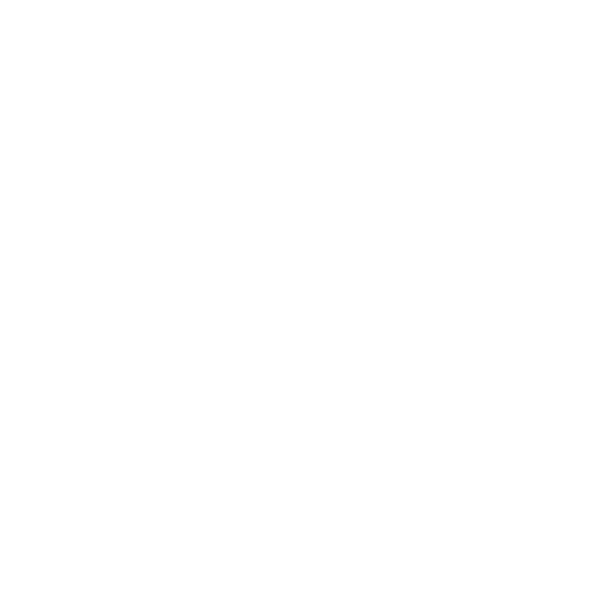

No handles with labels found to put in legend.


KeyboardInterrupt: 

In [23]:
plt.close()
anidev = animateDeviatoricSurface(out.time, out.Stress0, out.stress, out.StaticParam.Su)
anidev

<IPython.core.display.Javascript object>


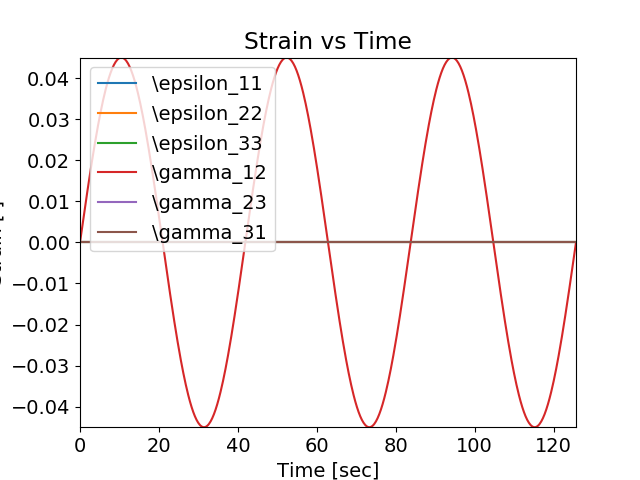

In [24]:
#%matplotlib inline
plt.close()
from matplotlib import pyplot as plt

fig = plt.figure
plt.ioff()
plt.plot(out.time, out.strain[0], label='\epsilon_11') 
plt.plot(out.time, out.strain[1], label='\epsilon_22') 
plt.plot(out.time, out.strain[2], label='\epsilon_33') 
plt.plot(out.time, out.strain[3], label='\gamma_12') 
plt.plot(out.time, out.strain[4], label='\gamma_23') 
plt.plot(out.time, out.strain[5], label='\gamma_31') 

# Customize plot for readability
plt.title(f'Strain vs Time')
plt.xlabel('Time [sec]')
plt.ylabel('Strain [ ]')
plt.legend(loc="upper left")  # Legend outside plot
plt.xlim(0, out.time.max())
plt.ylim(out.strain.min(), out.strain.max())
plt.tight_layout
plt.show()



In [25]:
x1 = out.time
xlabel1 = 'Time [s]'
y1 = out.strain[3]
ylabel1 = '$\gamma_{12}$'

x2 = out.time
xlabel2 = 'Time [s]'
y2 = out.stress[3]
ylabel2 = '\N{greek small letter tau}$_{12}$'

x3 = out.strain[0]
xlabel3 = '$\epsilon_{11}$'
y3 = out.stress[0]
ylabel3 = '$\sigma_{11}$'

x4 = out.strain[3]
xlabel4 = '$\gamma_{12}$'
y4 = out.stress[3]
ylabel4 = '\N{greek small letter tau}$_{12}$'
            
ani = quadSubplotAnimation()
HTML(ani.to_html5_video())
rc('animation', html='html5')
ani

In [26]:
traceStress, normDevStress = [], []
for i in range (0, out.stress.shape[1]):
    curTrace = sum(out.stress[0:3,i])
    traceStress.append(curTrace)
    devStress   = out.stress[0:6,i].reshape(6,1) - 1/3 * np.array([1, 1, 1, 0, 0, 0 ]).reshape(6,1) * curTrace
    devStress2  = np.multiply(devStress, devStress)
    normDevStress.append(np.sqrt( sum(devStress2[0:3,:]) + 2*sum(devStress2[3:6,:]) ))
traceStress = np.array([traceStress]).reshape(len(traceStress),1)
normDevStress = np.array([normDevStress]).reshape(len(normDevStress),1)

#Create sqrt2j2
sqrt2j2 = np.zeros((len(out.j2),1))
for i in range(0, len(out.j2)):    
    if out.j2[i] == 0:
        sqrt2j2[i]=0
    else:
        sqrt2j2[i] = (2*out.j2[i])**0.5

In [27]:
x1 = out.strain[3]
xlabel1 = '$\gamma_{12}$'
y1 = (out.stress[3]/out.StaticParam.G)*100
ylabel1 = '$100 * \N{greek small letter tau}_{12}/G$'

x2 = out.strain[3]
xlabel2 = '$\gamma_{12}$'
y2 = sqrt2j2
ylabel2 = '$\sqrt{2J_2}$'

x3 = traceStress
xlabel3 = 'tr($\sigma$) []'
y3 = normDevStress
ylabel3 = '||$\sigma\'$|| [MPa]'

x4 = out.time
xlabel4 = 'Time [s]'
y4 = out.Iter
ylabel4 = '# of Iterations'            
    
ani_misc = quadSubplotAnimation()
HTML(ani_misc.to_html5_video())
rc('animation', html='html5')
ani_misc

---
# BREAK

<IPython.core.display.Javascript object>


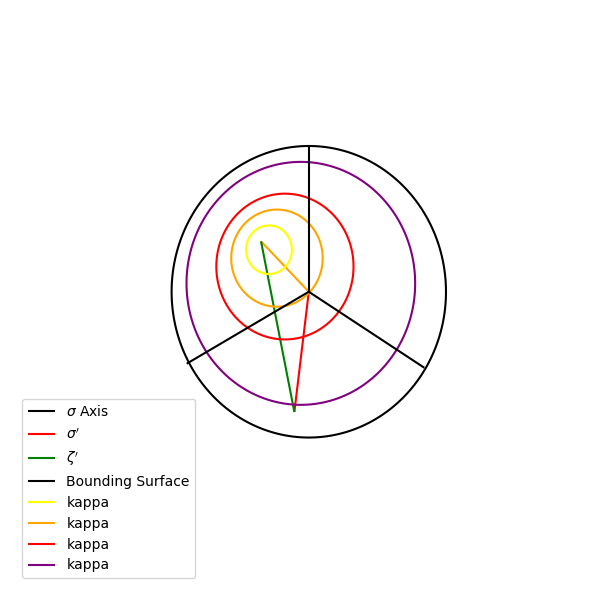

In [84]:
#======================================================
# DRAWING PSEUDO-2D REPRESENTATION OF DEVIATORIC SPACE
# Not animated, purely for a single stress state
#======================================================
import numpy as np
from collections import namedtuple
#%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Su = 0.061 #MPa
R = Su*(8/3)**0.5

Stress0 = np.array([2*R/3.0,0,R/2]).reshape(3,1)
CurStress = np.array([-np.sqrt(1/4)*R,np.sqrt(1/5)*R,np.sqrt(1/3)*R]).reshape(3,1)

drawDev = drawDeviatoricSurface_function(Stress0, CurStress, Su)
fig_dev = plt.figure('Deviatoric Surface')
ax = fig_dev.gca(projection='3d', proj_type = 'ortho')
font = {'size': 10}
matplotlib.rc('font', **font)
fig_dev.set_figheight(6)
fig_dev.set_figwidth(6)


#Plot reference lines
ax.plot_wireframe(drawDev.refLine1x, drawDev.refLine1y, drawDev.refLine1z, color = 'black', label='$\sigma$ Axis') 
ax.plot_wireframe(drawDev.refLine2x, drawDev.refLine2y, drawDev.refLine2z, color = 'black') 
ax.plot_wireframe(drawDev.refLine3x, drawDev.refLine3y, drawDev.refLine3z, color = 'black')

#Plot projected lines
ax.plot_wireframe(drawDev.dev_alphaLinex, drawDev.dev_alphaLiney, drawDev.dev_alphaLinez, color = 'orange')
ax.plot_wireframe(drawDev.dev_stressLinex, drawDev.dev_stressLiney, drawDev.dev_stressLinez, color = 'red', label = '$\sigma\'$')     
ax.plot_wireframe(drawDev.dev_zetaLinex, drawDev.dev_zetaLiney, drawDev.dev_zetaLinez.reshape(1,2), color = 'green', label='$\zeta\'$')   

#Plot axis
#ax.plot_wireframe(drawDev.dev_alphaAxisx, drawDev.dev_alphaAxisy, drawDev.dev_alphaAxisz, color = 'orange')
#ax.plot_wireframe(drawDev.dev_stressAxisx, drawDev.dev_stressAxisy, drawDev.dev_stressAxisz, color = 'red')
#ax.plot_wireframe(drawDev.hydroLinex, drawDev.hydroLiney, drawDev.hydroLinez, color = 'gray')

#Plot constitutive shapes
ax.plot_wireframe(drawDev.VMSurf[:,2], drawDev.VMSurf[:,1], drawDev.VMSurf[:,0].reshape(1,len(drawDev.VMSurf[:,0])), color = 'black', label='Bounding Surface')
#ax.plot_wireframe(drawDev.BSurf[:,2], drawDev.BSurf[:,1], drawDev.BSurf[:,0].reshape(1,len(drawDev.BSurf[:,0])), color = 'blue', label='Yield Surface')
ax.plot_wireframe(drawDev.BKSurfOne[:,2], drawDev.BKSurfOne[:,1], drawDev.BKSurfOne[:,0].reshape(1,len(drawDev.BKSurfOne[:,0])), color = 'yellow', label='kappa')
ax.plot_wireframe(drawDev.BKSurfTwo[:,2], drawDev.BKSurfTwo[:,1], drawDev.BKSurfTwo[:,0].reshape(1,len(drawDev.BKSurfTwo[:,0])), color = 'orange', label='kappa')
ax.plot_wireframe(drawDev.BKSurfThree[:,2], drawDev.BKSurfThree[:,1], drawDev.BKSurfThree[:,0].reshape(1,len(drawDev.BKSurfThree[:,0])), color = 'red', label='kappa')
ax.plot_wireframe(drawDev.BKSurfFour[:,2], drawDev.BKSurfFour[:,1], drawDev.BKSurfFour[:,0].reshape(1,len(drawDev.BKSurfFour[:,0])), color = 'purple', label='kappa')

#Set view to deviatoric space
#view(-45, -35.25)
ax.azim = 45
ax.elev = 38.5
#view([-0.5773 -0.5773 -0.5773])
plt.legend(loc="lower left")

#Make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

#Make the grid lines transparent
ax.set_axis_off()
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.tight_layout()
plt.show()


In [53]:
nCycles = 3
nPoints = 21
omega   = 0.15
time   = np.linspace(0, nCycles*2*np.pi/omega, nCycles*nPoints)
Su = 0.061 #Undrained shear strength, MPa
R = Su*(8/3)**0.5

nPoints = 21
nRevs = 10/3
p = np.linspace(0,nRevs*2*np.pi,nCycles*nPoints)
a = 3*R
k = R*np.sqrt(2)/2

# Spiral
x=a*np.e**(k*p)*np.sin(p)
y=a*np.e**(k*p)*np.cos(p)
y = y-a; y = -y # Center and flip
Stress0 = np.array([[np.sqrt(2/3)*R],[0],[0]])*y + np.array([[0],[(1/2)*R],[-(1/2)*R]])*x
Stress0 = np.append(Stress0, np.flip(Stress0,1),1).reshape(3,2*nCycles*nPoints) # Reverse path at end, aesthetic

#CurStress = np.array([[np.sqrt(3/2)*R],[0.000],[0.000]]) * np.sin( omega*time )     
CurStress = np.array([[1/2*R],[0],[0]]) * np.cos( omega*time * 2*np.pi/3 ) + np.array([[-1/5*R],[1/3*R],[2/3*R]]) * np.sin( omega*time * 1*np.pi/3 )
CurStress = np.append(CurStress, np.flip(CurStress,1)).reshape(3,2*nCycles*nPoints)

time = np.append(time,time[::-1]) # Reverse path at end, aesthetic

anidev = animateDeviatoricSurface(time, Stress0, CurStress, Su)
anidev

---
## Radial Loading and Exponential Model

$$ (1+\kappa)\bar{\sigma} - \kappa\bar{\sigma}_0 = \bar{R} $$

$$ H' = \frac{E_i E_t}{E_i - E_t} = h (\frac{\bar{R} - \bar{\sigma}}{\bar{\sigma} - \bar{\sigma}_0})^m $$

$$ d\bar{{\epsilon}} = \frac{d\bar{{\sigma}}}{3\mu} + \left (\frac{\bar{{\sigma}} - \bar{{\sigma_0}}}{\bar{R} - \bar{{\sigma}}}\right)^{m} \frac{d\bar{{\sigma}}}{h} $$

$$ \bar{\epsilon} = \frac{\bar{\sigma}}{3\mu} + \frac{1}{h}\int_{0}^{\bar{\sigma}} \left(\frac{\zeta}{\bar{R} - \zeta} \right)^{m} d\zeta $$

$$ 2\bar{\epsilon_1} = \frac{2\bar{\sigma_1}}{3\mu} + \frac{1}{h}\int_{-\bar{\sigma}}^{\bar{\sigma}} \left(\frac{\zeta + \bar{\sigma_1}}{\bar{R} - \zeta} \right)^{m} d\zeta $$

$$ \left ( \frac{\bar{\mu}}{\mu}\right)^{-1} = 1 + \frac{3\mu}{2h}\int_{0}^{2\bar{\sigma_1}} \left ( \frac{\zeta}{\bar{R} + \bar{\sigma_1} - \zeta} \right )^{m} d\zeta $$

---
$$\lambda = \frac{1}{2\pi}\frac{\Delta E}{\bar{\mu}\gamma^2} $$

